In [1]:
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import gensim
import gzip
import nltk
import re
import keras.backend as K

from keras.optimizers import Adam, Adadelta
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter, defaultdict
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import SGD



In [9]:
import os

filename = "embeddings_word2vec.txt"
embeddings_index = {}
f = open(os.path.join('', filename), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [48]:
df = df.rename(columns={'type': 'personalities'})

In [49]:
sentences = []
mbti = []

for post in range(len(df.posts)):
    sentences.append(df['posts'].iloc[post])
    mbti.append(df['personalities'].iloc[post])

max_length = max([len(sentence.split()) for sentence in sentences])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)



word_index = tokenizer.word_index

print('Found %s unique tokens' % len(word_index))


sequences_padded = pad_sequences(sequences, maxlen=max_length)

print("Shape of the posts tensor", sequences_padded.shape)


Found 117871 unique tokens
Shape of the posts tensor (8000, 1938)


In [17]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 150))

for word, i in word_index.items():
    if i > num_words: continue
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)

NameError: name 'embeddings_index' is not defined

In [76]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def prepare_labels(y_train, y_test):
    OHE = OneHotEncoder()
    OHE.fit(y_train)
    y_train_enc = OHE.transform(y_train)
    y_test_enc = OHE.transform(y_test)
    return y_train_enc, y_test_enc

In [3]:
#preprocessing these motherfuckers with scikit-learn...
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
dataset = df.values

X = dataset[:,-1]
Y = dataset[:,0]


#cv = CountVectorizer(stop_words='english')
all_features = cv.fit_transform(X)

X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(all_features, Y, test_size=0.33, random_state=1)



#X_train_sk, X_test_sk = prepare_inputs(X_train_sk, X_test_sk)
y_train_sk, y_test_sk = prepare_labels(y_train_sk, y_test_sk)

NameError: name 'df' is not defined

In [79]:

dataset = df.values
Y = dataset[:,0]
VALIDATION_SPLIT = 0.3

Y = Y.reshape(len(Y), 1)

indicies = np.arange(sequences_padded.shape[0])
np.random.shuffle(indicies)
sequences_padded =sequences_padded[indicies]

num_validation_samples = int(VALIDATION_SPLIT * sequences_padded.shape[0])
X_train_pad = sequences_padded[:-num_validation_samples]
X_test_pad = sequences_padded[-num_validation_samples:]

y_train = Y[:-num_validation_samples]
y_test = Y[-num_validation_samples:]





In [80]:
print("Shape of X_train_pad", X_train_pad.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_test_pad", X_test_pad.shape)
print("Shape of y_test", y_test.shape)

y_test

Shape of X_train_pad (5600, 1938)
Shape of y_train (5600, 1)
Shape of X_test_pad (2400, 1938)
Shape of y_test (2400, 1)


array([['INTJ'],
       ['ESFP'],
       ['INFJ'],
       ...,
       ['ENFJ'],
       ['ESFJ'],
       ['ENTJ']], dtype=object)

In [81]:


y_train, y_test = prepare_labels(y_train, y_test)

In [82]:
y_train

<5600x15 sparse matrix of type '<class 'numpy.float64'>'
	with 5600 stored elements in Compressed Sparse Row format>

In [83]:
embedding_dim = 512
num_words = len(word_index) + 1
inputs = tf.keras.Input(shape=(max_length,))

embedding_layer = Embedding(input_dim=num_words,
                           output_dim=embedding_dim,
                           input_length=max_length)(inputs)

gru = tf.keras.layers.Bidirectional(GRU(units=256, return_sequences=True))(embedding_layer)


flatten = Flatten()(gru)

outputs = Dense(1, activation='sigmoid')(flatten)

#lr_schedule = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)

model = tf.keras.Model(inputs, outputs)

model.compile(loss= "categorical_crossentropy", optimizer='adam', metrics=['accuracy',
                                                                     tf.keras.metrics.AUC(name='auc')])



In [90]:
#BUILDING ANOTHER MODEL USING SEQUENTIAL JIC
embedding_dim=150

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))

model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=SGD(lr=0.01), metrics=['accuracy',
                                                                     tf.keras.metrics.AUC(name='auc')])

In [69]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-1, steps_per_epoch=np.ceil(125), epochs=5)
    

In [70]:
model.fit(X_train_pad, y_train, batch_size=64, callbacks=[lr_finder], verbose=2)

88/88 - 534s - loss: 0.0000e+00 - accuracy: 0.0586 - auc: 0.4911


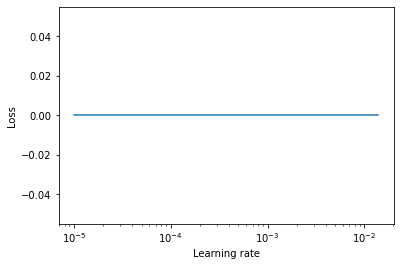

In [71]:
lr_finder.plot_loss()

In [ ]:
model.fit(X_train_pad, 
          y_train, 
          batch_size=64, 
          epochs=25,
          validation_data=(X_test_pad, y_test),
          callbacks=[tf.keras.callbacks.ModelCheckpoint('./personality_model.h5', save_best_only=True, save_weights_only=True)],
          verbose=2)

Epoch 1/25


In [ ]:
#run model tests here after you continue working....

In [22]:
results = model.evaluate(X_test_pad, y_test, batch_size=128)

12/12 [==============================] - 211s 17s/step - loss: 0.0000e+00 - accuracy: 0.0611 - auc: 0.5000


In [24]:
# LRFinder by jeremyjordan on Github:

# LRFinder by jeremyjordan on Github:

import matplotlib.pyplot as plt
import keras.backend as K
from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [4]:
df = iFuckedUp_savingDf()

In [2]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
    
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
    
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def preprocess(posts):
    lemmatizer = WordNetLemmatizer()
    
    new_posts = cleanHtml(posts)
    new_posts = cleanPunc(new_posts)
    new_posts = keepAlpha(new_posts)
   
    
    return_posts = " ".join(lemmatizer.lemmatize(word, pos="v") for word in new_posts.split())
    return return_posts
    
    

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/aiwarriors/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def iFuckedUp_savingDf():
    df = pd.read_csv('DfFinal.csv')
    df_original_posts = pd.read_csv("mbti_1.csv")['posts']
    df_original_posts = pd.DataFrame(df_original_posts)
    df = df.drop(['posts'], axis=1)
    df = df.join(df_original_posts)
    
    for i in range(len(df.index)):
        df.at[i, 'posts'] = preprocess(" ".join(df['posts'].iloc[i].split('|||')))
    df.to_csv('DfFinal.csv')
    return df

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Unnamed: 0,type,posts
0,24,ENTJ,Oooi Jully Beans Bem vinda ao PerC Ok n o sei ...
1,3799,INFJ,g w Its good for her then cause I be a beast w...
2,814,ESFJ,Have yall give people the impression you where...
3,2280,INFJ,Here go Excuse my lowkey high look be sick all...
4,2851,ENFJ,the maltese falcon and the usual suspect i fin...
...,...,...,...
4795,3988,INFP,http www youtube com watchv jfTNcewDKS Im not ...
4796,8658,ESFJ,Yoda We havent be cook long enough put us back...
4797,2352,INFP,This isnt even an I feel like statement anymor...
4798,54,INFP,Noted that I have be note Also its you shock I...


In [9]:
df = df.drop(columns=['level_0', 'index'])

KeyError: "['level_0' 'index'] not found in axis"

In [7]:
df = df.dropna()
df

,personalities,posts
0,ESFP,I loathe BuzzFeed https www youtube com watchv...
1,ESTP,Yes I get this all the time At least some of m...
2,ENFP,I think I should have read The Dubliners earli...
3,ESFJ,Whoa ive be go for close to months and the pla...
4,INTP,Sorry to hear about what youre go through That...
...,...,...
7995,ISFJ,Yes its a lot like a chess game Ive be in a si...
7996,ESFP,http www youtube com watchv epRB P vvE Cute EN...
7997,INFP,When someone immediately dismiss anything I ha...
7998,ISFP,https www youtube com watchv LozrF EHf Q Youve...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

cv = TfidfVectorizer()
X = cv.fit_transform(df.posts).toarray()

X = pd.DataFrame(X)
X.reindex(np.random.permutation(X.index))

X_tr, X_te, y_tr, y_te = train_test_split(X, df.values[:,0], test_size=0.33, random_state=1, shuffle=False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import numpy as np

nbclf=gbc()
parameters = {
    #"loss":["deviance"],
     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
     "n_estimators":[10,15,20,30,50,75,100]
    }
clf = GridSearchCV(nbclf, parameters,scoring='accuracy',refit=False,cv=2, n_jobs=-1)
clf.fit(X_tr,y_tr)

clf.bestparams

In [ ]:
model.load_weights('./model.h5')

In [ ]:
model.evaluate(texts_test, labels_test)